# xgboost

## Fit a model and make global and local explanations


Predict whether a student will dropout from their class.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split

import xgboost as xgb
from xgboost import plot_importance

import eli5

from feature_engine.selection import SmartCorrelatedSelection

## Load data

To obtain the data, check the folder `prepare-data` in this repo, or section 2 in the course.

In [2]:
df = pd.read_csv('../../student_dropout_trees.csv')

print(df.shape)

df.head()

(4424, 33)


,Marital status,Application mode,Application order,Course,Daytime/evening attendance\t,Previous qualification,Previous qualification (grade),Nacionality,Admission grade,Displaced,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,dropout
0,0,0,5,0,1,0,122.0,0,127.3,1,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,1
1,0,1,1,1,1,0,160.0,0,142.5,1,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,0
2,0,2,5,2,1,0,122.0,0,124.8,1,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,1
3,0,0,2,3,1,0,122.0,0,119.6,1,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,0
4,1,3,1,4,0,0,100.0,0,141.5,0,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,0


In [3]:
# Split the data

X_train, X_test, y_train, y_test = train_test_split(
    df.drop("dropout", axis=1),
    df["dropout"],
    test_size=0.2,
    random_state=1,
)

X_train.shape, X_test.shape

((3539, 32), (885, 32))

In [4]:
# Fraction of students who drops out.

y_train.mean(), y_test.mean()

(0.3241028539135349, 0.3096045197740113)

## xgboost

Train an XGBoost classifier.

In [5]:
# fit model

model = xgb.XGBClassifier(n_estimators=10, random_state=42)

model.fit(X_train, y_train)

print(f"Accuracy in train set: {model.score(X_train, y_train)}")
print(f"Accuracy in test set: {model.score(X_test, y_test)}")

Accuracy in train set: 0.9115569369878497
Accuracy in test set: 0.8632768361581921


The model is a good fit of the data.

## Feature importance - global

C:\Users\Sole\Documents\Repositories\envs\fsml\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


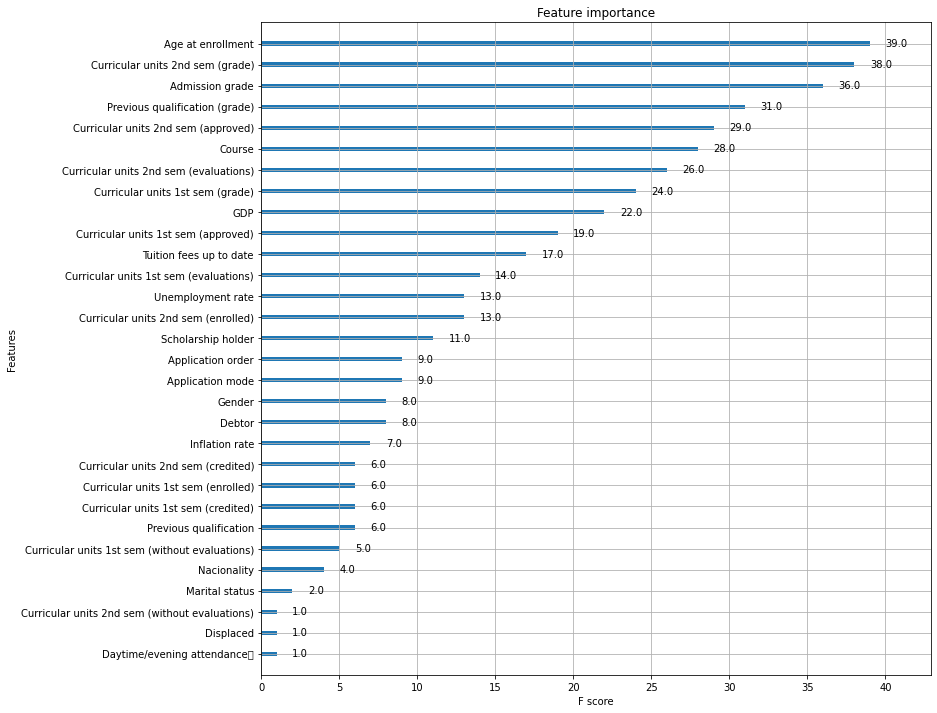

In [6]:
# Plot the feature importances with xgb library

fig, ax = plt.subplots(figsize=(12, 12))
plot_importance(model, ax=ax)
plt.show()

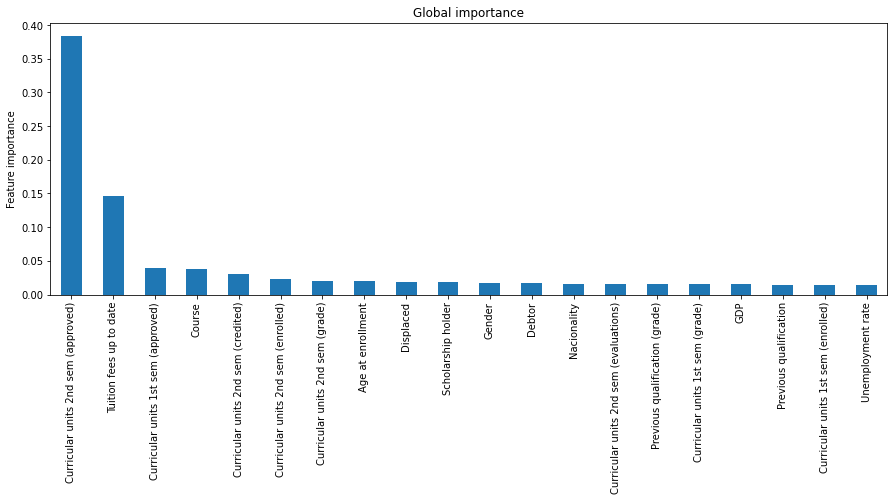

In [7]:
# Plot the feature importances with sklearn

s = pd.Series(
    model.feature_importances_,
    index=model.feature_names_in_,
)

s.sort_values(ascending=False).head(20).plot.bar(figsize=(15,5))
plt.ylabel("Feature importance")
plt.title("Global importance")
plt.show()

## Remove correlated variables

Identify groups of variables that are correlated and retain the one with the greatest variability.

In [8]:
# I use this transformer from Feature-engine, but you may have as
# well done this manually.

sel = SmartCorrelatedSelection(threshold=0.8, selection_method='variance').fit(
    X_train, y_train)

# Retain variable with highest variability from
# each group

X_train = sel.transform(X_train)
X_test = sel.transform(X_test)

X_train.shape, X_test.shape

((3539, 28), (885, 28))

## xgboost - take 2

In [9]:
# fit model

model = xgb.XGBClassifier(n_estimators=10, random_state=42)

model.fit(X_train, y_train)

print(f"Accuracy in train set: {model.score(X_train, y_train)}")
print(f"Accuracy in test set: {model.score(X_test, y_test)}")

Accuracy in train set: 0.9039276631816897
Accuracy in test set: 0.864406779661017


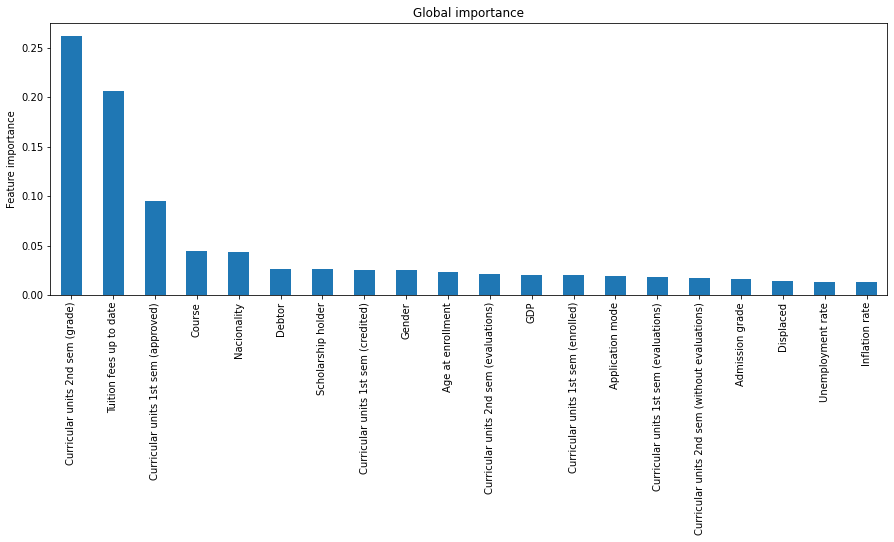

In [10]:
# Plot the feature importances with sklearn

s = pd.Series(
    model.feature_importances_,
    index=model.feature_names_in_,
)

s.sort_values(ascending=False).head(20).plot.bar(figsize=(15,5))
plt.ylabel("Feature importance")
plt.title("Global importance")
plt.show()

Note the change in importance in some features after removing their correlated counterparts.

## Local explanations

Evaluate observations 44 and 3411 from the test set and draw some conclusions.

In [11]:
X_test.head()

,Marital status,Application mode,Application order,Course,Daytime/evening attendance\t,Previous qualification,Previous qualification (grade),Nacionality,Admission grade,Displaced,...,Curricular units 1st sem (enrolled),Curricular units 1st sem (evaluations),Curricular units 1st sem (approved),Curricular units 1st sem (without evaluations),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP
44,0,3,1,5,0,0,133.1,0,109.7,0,...,5,0,0,0,0,0.000000,0,16.2,0.3,-0.92
3411,0,0,4,6,1,0,129.0,0,120.0,1,...,8,8,7,0,8,12.454286,0,10.8,1.4,1.74
4212,0,0,2,3,1,0,125.0,0,115.6,1,...,6,6,6,0,6,14.666667,0,12.4,0.5,1.79
3037,0,2,1,8,1,0,126.0,0,126.7,1,...,6,6,6,0,9,13.000000,0,8.9,1.4,3.51
1672,0,6,1,11,1,3,130.0,0,130.0,1,...,6,12,5,0,10,12.000000,0,16.2,0.3,-0.92


In [12]:
eli5.show_prediction(
    model, 
    X_test.loc[44], 
    feature_names=model.feature_names_in_,
)

For this student there is a high chance of dropout. The variables in green are those that increased their probability of dropout. 

In [13]:
eli5.show_prediction(
    model, 
    X_test.loc[3411], 
    feature_names=model.feature_names_in_,
)

Go ahead and evaluate other students and see how these values change.